In [ ]:
!pip3 install -U scikit-learn scipy matplotlib

# New section

In [ ]:
!pip3 install graphviz

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('secondary_data.csv', delimiter=';')

data_encoded = pd.get_dummies(data)
data_encoded = data_encoded.astype(int)

X = data_encoded.drop(['class_p', 'class_e'], axis=1)
y = data_encoded['class_p']

In [ ]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None # Returns True if the node is a leaf node

class TreeModel:
    def __init__(self, max_depth=None, max_leaf_nodes=None, entropy_threshold=None, split_function='gini', min_samples_split=2, feature_names=None):
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.entropy_threshold = entropy_threshold
        self.split_function = split_function
        self.min_samples_split = min_samples_split
        self.root = None
        self.leaf_count = 0
        self.depth = 0
        self.criterion_func = self._get_criterion_func(split_function)
        self.feature_names = feature_names

    def get_params(self, deep=True):
        return {
            'max_depth': self.max_depth,
            'max_leaf_nodes': self.max_leaf_nodes,
            'entropy_threshold': self.entropy_threshold,
            'split_function': self.split_function,
            'min_samples_split': self.min_samples_split,
            'feature_names': self.feature_names
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    # Helper method to get the specific criterion function based on input
    def _get_criterion_func(self, method):
        if method == 'scaled_entropy':
            return self._scaled_entropy
        elif method == 'gini':
            return self._gini_impurity
        elif method == 'squared':
            return self._squared_impurity
        raise ValueError("split_function must be 'scaled_entropy', 'gini', or 'squared'")

    # Method to fit the tree using the data provided (features and labels).
    def fit(self, X, y):
        self.leaf_count = 0
        self.depth = 0
        self.root = self._grow_tree(X, y)  # Start growing the tree from the root.

    # Recursive function to grow tree from the provided data, starting at the given depth.
    def _grow_tree(self, X, y, depth=0):
        num_samples = y.size  # Number of samples in the current node.
        if num_samples < self.min_samples_split or len(np.unique(y)) == 1:
            return TreeNode(value=self._most_common_label(y))  # Return a leaf node if stopping conditions are met.

        if self.max_depth is not None and depth >= self.max_depth:
            return TreeNode(value=self._most_common_label(y))  # Limit tree depth.

        current_entropy = self.criterion_func(y)
        if self.max_leaf_nodes is not None and self.leaf_count >= self.max_leaf_nodes:
            return TreeNode(value=self._most_common_label(y))  # Limit number of leaf nodes.

        if self.entropy_threshold is not None and current_entropy < self.entropy_threshold:
            return TreeNode(value=self._most_common_label(y))  # Stop if entropy is below the specified threshold.

        self.depth = max(self.depth, depth)  # Update tree depth.
        best_gain = -np.inf  # Initialize the best information gain found so far.
        best_feat, best_thresh = None, None  # Initialize the best feature and threshold to split.

        # Iterate over all features.
        for feat_idx in range(X.shape[1]):
            values, counts = np.unique(X[:, feat_idx], return_counts=True)  # Unique values and their counts in the feature.
            for value in values:
                left_mask = X[:, feat_idx] <= value  # Samples that go to the left child.
                right_mask = ~left_mask  # Samples that go to the right child.
                if np.sum(left_mask) < 2 or np.sum(right_mask)< 2:
                    continue  # Skip splits that do not distribute the data.
                gain = self._gain(y, left_mask, right_mask, current_entropy)  # Calculate information gain.
                if gain > best_gain:  # Check if this split is better than the best so far.
                    best_gain = gain
                    best_feat, best_thresh = feat_idx, value

        if best_feat is None:
          return TreeNode(value=self._most_common_label(y))  # All features have been checked, return a leaf node if no split was found.

        self.leaf_count += 1
        left_mask = X[:, best_feat] <= best_thresh  # Left samples after finding the best split.
        right_mask = ~left_mask  # Right samples.
        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)  # Recursively grow left subtree.
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)  # Recursively grow right subtree.
        return TreeNode(feature=best_feat, threshold=best_thresh, left=left, right=right)  # Return the current node with learned split.

    # Helper to calculate information gain based on a split.
    def _gain(self, y, left_mask, right_mask, parent_criterion):
        n = y.size  # Total sample size.
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)  # Number of samples in each child.
        return parent_criterion - (n_left / n * self.criterion_func(y[left_mask]) + n_right / n * self.criterion_func(y[right_mask]))

    # Scaled entropy impurity calculation.
    def _scaled_entropy(self, y):
        probs = np.bincount(y, minlength=np.max(y)+1) / len(y)
        return -0.5 * np.sum(probs * np.log2(probs + np.finfo(float).eps))

    # Gini impurity calculation.
    def _gini_impurity(self, y):
        probs = np.bincount(y, minlength=np.max(y)+1) / len(y)
        return 1.0 - np.sum(probs**2)

    # Squared impurity calculation.
    def _squared_impurity(self, y):
        probs = np.bincount(y, minlength=np.max(y)+1) / len(y)
        return np.sum(np.sqrt(probs * (1 - probs)))

    # Method to predict the label of new samples.
    def predict(self, X):
        predictions = np.apply_along_axis(self._traverse_tree, 1, X, self.root)
        return predictions

    # Recursive helper to traverse the tree based on features until a leaf node is reached.
    def _traverse_tree(self, x, node):
        while not node.is_leaf():
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.value  # Return the classification result from the leaf.

    def _most_common_label(self, y):
        return np.argmax(np.bincount(y))

    def visualize_tree(self):
        def add_nodes_edges(node, dot=None):
            if dot is None:
                dot = graphviz.Digraph()
                label = (
                    f"{'Leaf' if node.is_leaf() else 'Node'}"
                    f"{'Feature=' + str(node.feature) if node.feature is not None else ''}"
                    f"{'Threshold=' + str(node.threshold) if node.threshold is not None else ''}"
                )
                dot.node(name=str(id(node)), label=label, shape='box' if node.is_leaf() else 'ellipse')

            if node.left:
                label_left = (
                    f"{'Leaf' if node.left.is_leaf() else 'Node'}"
                    f"{'Feature=' + str(node.left.feature) if node.left.feature is not None else ''}"
                    f"{'Threshold=' + str(node.left.threshold) if node.left.threshold is not None else ''}"
                )
                dot.node(name=str(id(node.left)), label=label_left, shape='box' if node.left.is_leaf() else 'ellipse')
                dot.edge(str(id(node)), str(id(node.left)), label="True")
                add_nodes_edges(node.left, dot=dot)

            if node.right:
                label_right = (
                    f"{'Leaf' if node.right.is_leaf() else 'Node'}"
                    f"{'Feature=' + str(node.right.feature) if node.right.feature is not None else ''}"
                    f"{'Threshold=' + str(node.right.threshold) if node.right.threshold is not None else ''}"
                )
                dot.node(name=str(id(node.right)), label=label_right, shape='box' if node.right.is_leaf() else 'ellipse')
                dot.edge(str(id(node)), str(id(node.right)), label="False")
                add_nodes_edges(node.right, dot=dot)

            return dot

        # Starting the graph from root
        dot = add_nodes_edges(self.root)
        return dot

In [ ]:
from sklearn.model_selection import GridSearchCV

# Assume TreeModel has been adapted to fit into the sklearn framework
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'entropy_threshold': [0.1, 0.2, 0.3]
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tree = TreeModel(
    max_depth=None,
    max_leaf_nodes=None,
    entropy_threshold=0.2,
    split_function="gini",
    min_samples_split=2,
    feature_names=X.columns,
)

grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train.values, y_train.values)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'entropy_threshold': 0.1, 'max_depth': None, 'min_samples_split': 2}
Best cross-validation score: 0.98


train_acc: 0.9803090778835329
val_accuracy: 0.978876698870149


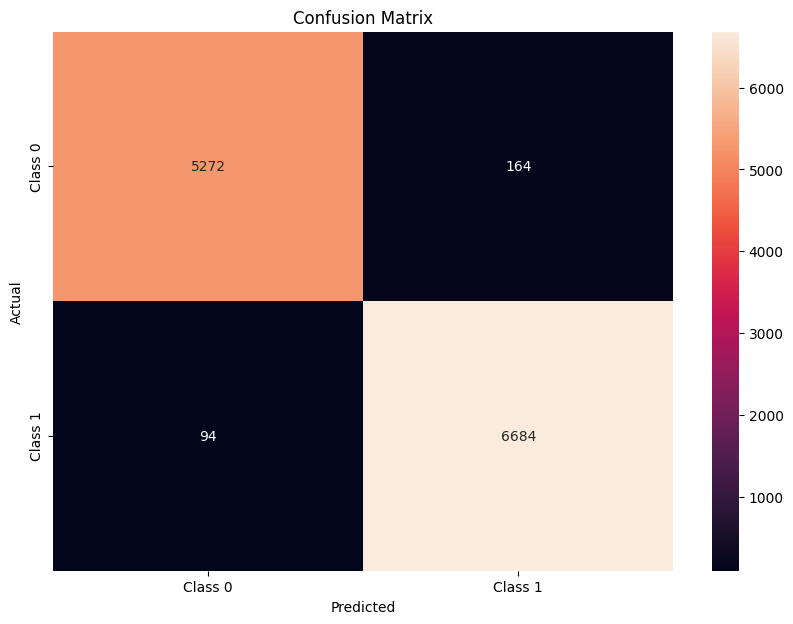

In [ ]:
tree = TreeModel(
    max_depth=None,
    max_leaf_nodes=None,
    entropy_threshold=0.1,
    split_function="gini",
    min_samples_split=2,
    feature_names=X.columns,
)

tree.fit(X_train.values, y_train.values)
y_train_pred = tree.predict(X_train.values)
y_test_pred = tree.predict(X_test.values)

train_acc = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_test, y_test_pred)
print('train_acc:', train_acc)
print('val_accuracy:', val_accuracy)

conf_matrix = confusion_matrix(y_test.values, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dot = graphviz.Digraph()
dot = tree.visualize_tree()

dot.render(format='png', view=True)